In [1]:
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers import observation_space
import numpy as np
from matplotlib import pyplot as plt
env = gym.make('ppaquette/DoomDefendLine-v0')

[2017-09-24 03:42:18,777] Making new env: ppaquette/DoomDefendLine-v0


In [2]:
import itertools
import random as rd

In [35]:
from doom_py import ScreenResolution

In [228]:
rd.choice([1,2])

2

In [ ]:
import gym
import ppaquette_gym_doom
env = gym.make('ppaquette/DoomDefendLine-v0')
env.reset()
for _ in range(5000):
    env.render()
    env.step(env.action_space.sample())

In [36]:
wrapper = observation_space.SetResolution('320x240')
env = wrapper(env)

In [110]:
# THIS IS FOR 5 FRAMES
for i_episode in range(1):
    observation = env.reset()
    for t in range(1):
        env.render()
        # print(observation.shape)
        action = [0]*43
        action[14] = 1
        observation, reward, done, info = env.step(action)
        frames = observation[188:235, 40:600]
        frame1 = frames[:, 1:108]
        frame2 = frames[:, 109:216]
        frame3 = frames[:, 217:324]
        frame4 = frames[:, 325:432]
        frame5 = frames[:, 433:600]
        rgb_frame1 = np.mean(frame1, axis=(0, 1))
        rgb_frame2 = np.mean(frame2, axis=(0, 1))
        rgb_frame3 = np.mean(frame3, axis=(0, 1))
        rgb_frame4 = np.mean(frame4, axis=(0, 1))
        rgb_frame5 = np.mean(frame5, axis=(0, 1))
        print(frame1.shape)
        print(rgb_frame1)
        print(rgb_frame2)
        print(rgb_frame3)
        print(rgb_frame4)
        print(rgb_frame5)
        plt.imshow(frame1)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

(47, 107, 3)
[ 85.87373235  65.64068403  47.65937562]
[ 88.24537681  61.66036985  47.70888845]
[ 102.05448399   72.32869358   58.99244383]
[ 85.94571485  60.28454961  46.4472062 ]
[ 86.07522198  65.82124309  47.79745351]


In [3]:
def actionToAngle(action):
    return {
        'right': 3,
        'left': -3,
        'shoot': 0
    }.get(action, 0)  # 0 default if action not found 

def angleToState(angle):
    return {
        0: 1,
        3: 1,
        6: 2,
        9: 2,
        12: 3,
        15: 3,
        18: 4,
        21: 4,
        24: 5,
        27: 5,
        30: 6,
        -3: 1,
        -6: 7,
        -9: 7,
        -12: 8,
        -15: 8,
        -18: 9,
        -21: 9,
        -24: 10,
        -27: 10,
        -30: 11,
    }.get(angle, 0)

def next_possible_states(current_state):
    return {
        1: (2,7),
        2: (1,3),
        3: (2,4),
        4: (3,5),
        5: (4,6),
        6: (5,0),
        0: (6,11),
        11: (0,10),
        10: (11,9),
        9: (10,8),
        8: (9,7),
        7: (8,1)
    }.get(current_state, 'error')

In [7]:
np.array(next_possible_states(2))
angleToState(9)
x = [1,2,3]

In [10]:
x.index(rd.choice(x))

2

In [193]:
def frameToFind(a):
#     print(a)
    a = a.tolist()
    if a[0]>100:
        return 1
    elif a[0] < 96 and a[0] > 79:
        return 0
    elif a[0] < 78 and a[0] > 73:
        return 1
    else:
        return 0

In [21]:
# this is for Q learning!!!
epsilon = 0.9
Q = np.zeros([12, 3])  # states, actions 
discount_factor = 0.9
alpha = 0.1
num_episodes = 500
scores_list = []
for i_episode in range(500):
    observation = env.reset()
    
    angle = 0
    # the first state is based on the angular position of the hand
    current_state = 1 # 1 because we always start facing the demons
    
    score = 0   
    for t in itertools.count():
        env.render()
        # print(observation.shape)
        
        set_of_actions = ['right', 'left', 'shoot'] # index 0, 1, and 2
        # decision process
        # generate a random num between 0 and 1 e.g. 0.35, 0.73 etc..
        # if the generated num is smaller than epsilon, we follow exploration policy 
        if np.random.random() <= epsilon:
            # select a random action from set of all actions
            index_action = set_of_actions.index(rd.choice(set_of_actions))
            action = set_of_actions[index_action]
        # if the generated num is greater than epsilon, we follow exploitation policy
        else:
            # select an action with highest value for current state
            index_action = np.argmax(Q[current_state, :])
            action = set_of_actions[index_action]
        
        # 'left'
        actionVector = [0]*43
        if action == 'left':
            actionVector[15] = 1
        elif action == 'right':
            actionVector[14] = 1
        elif action == 'shoot':
            actionVector[0] = 1
        else:
            print("error in action")
        
        # apply selected action, collect values for next_state and reward
        observation, reward, done, info = env.step(actionVector)
        
        score = score+reward
        next_states = np.array(next_possible_states(current_state))
        
        # Calculate the Q-learning target value
        Q_target = reward + discount_factor*np.max(Q[next_states,:])
        # Calculate the difference/error between target and current Q
        Q_delta = Q_target - Q[current_state,index_action]
        # Update the Q table, alpha is the learning rate
        Q[current_state, index_action] = Q[current_state, index_action] + (alpha * Q_delta)
        
        
        angle += actionToAngle(action)
        if angle > 90:
            angle = -87
        if angle < -90:
            angle = 87
        current_state = angleToState(angle)
        

        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print(Q)
            scores_list.append(score)
            print(scores_list)
            break
            
    # gradualy decay the epsilon
    if epsilon > 0.1:
        epsilon -= 1.0/num_episodes

Episode finished after 675 timesteps
[[ 0.0985857   0.09833824  0.0760416 ]
 [ 0.05080511  0.00663612  0.00604787]
 [ 0.02832002  0.03392641  0.00457246]
 [ 0.00580142  0.0028043   0.00305338]
 [ 0.01791882  0.00900804  0.01711527]
 [ 0.08982364  0.04859781  0.11718802]
 [ 0.05900306  0.02928205  0.10923479]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[13.0]
Episode finished after 537 timesteps
[[ 0.20319656  0.22376386  0.18184122]
 [ 0.15827252  0.01687403  0.01070019]
 [ 0.04414179  0.08544275  0.05768017]
 [ 0.19794045  0.26669114  0.20808512]
 [ 0.26542041  0.24760413  0.26733573]
 [ 0.2525614   0.30121896  0.21689024]
 [ 0.20798342  0.2187669   0.24989826]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.    

In [18]:
# this is for SARSA learning!!!
epsilon = 0.9
Q = np.zeros([12, 3])  # states, actions 
discount_factor = 0.9
alpha = 0.1
num_episodes = 15
scores_list = []
for i_episode in range(15):
    observation = env.reset()
    
    angle = 0
    # the first state is based on the angular position of the hand
    current_state = 1 # 1 because we always start facing the demons
    # random action
    set_of_actions = ['right', 'left', 'shoot'] # index 0, 1, and 2
    current_index_action = set_of_actions.index(rd.choice(set_of_actions))
    action = set_of_actions[current_index_action]
    
    score = 0
    for t in itertools.count():
        env.render()
        # print(observation.shape)      
        
       
        angle += actionToAngle(action)
        if angle > 90:
            angle = -87
        if angle < -90:
            angle = 87
        next_state = angleToState(angle)
         
        # decision process
        # generate a random num between 0 and 1 e.g. 0.35, 0.73 etc..
        # if the generated num is smaller than epsilon, we follow exploration policy 
        if np.random.random() <= epsilon:
            # select a random action from set of all actions
            next_index_action = set_of_actions.index(rd.choice(set_of_actions))
            next_action = set_of_actions[next_index_action]
        # if the generated num is greater than epsilon, we follow exploitation policy
        else:
            # select an action with highest value for current state
            next_index_action = np.argmax(Q[current_state, :])
            next_action = set_of_actions[next_index_action]
        
        # 'left'
        actionVector = [0]*43
        if action == 'left':
            actionVector[15] = 1
        elif action == 'right':
            actionVector[14] = 1
        elif action == 'shoot':
            actionVector[0] = 1
        else:
            print("error in action")
        
        # apply selected action, collect values for next_state and reward
        observation, reward, done, info = env.step(actionVector)
        score = score + reward
        
        # Calculate the Q-learning target value
        Q_target = reward + discount_factor*(Q[next_state, next_index_action])
        # Calculate the difference/error between target and current Q
        Q_delta = Q_target - Q[current_state,current_index_action]
        # Update the Q table, alpha is the learning rate
        Q[current_state, current_index_action] = Q[current_state, current_index_action] + (alpha * Q_delta)
        
        
        current_state = next_state
        action = next_action
        current_index_action = next_index_action

        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print(Q)
            scores_list.append(score)
            break
            
    # gradualy decay the epsilon
    if epsilon > 0.1:
        epsilon -= 1.0/num_episodes

Episode finished after 1115 timesteps
[[  7.37430241e-02  -2.74370155e-02   7.26507967e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.00000000e-02]
 [  1.11542756e-04   0.00000000e+00   1.05697006e-05]
 [  2.57535309e-02   2.66105133e-04   0.00000000e+00]
 [  1.17899316e-01   2.16273030e-03   6.53146316e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]
Episode finished after 578 timesteps
[[ 0.08905706  0.17216382 -0.01756979]
 [ 0.          0.          0.        ]
 [ 0.09        0.          0.        ]
 [ 0.0113472   0.00708903  0.06529929]
 [ 0.00836259  0.06755796  0.00681918]
 [ 0.09969174  0.00761246  0.01106065]
 [ 0.09991292  0.01934497  0.06531463]
 [ 

In [22]:
env.close()

In [20]:
scores_list

[13.0,
 9.0,
 21.0,
 12.0,
 11.0,
 8.0,
 15.0,
 17.0,
 8.0,
 15.0,
 14.0,
 15.0,
 6.0,
 12.0,
 12.0]

In [194]:
# THIS IS FOR 10 FRAMES!!!
for i_episode in range(1):
    observation = env.reset()
    
    angle = 0
    current_state = [0]*11 # our state is a vector of 11 elements
    # the first state is based on the angular position of the hand
    current_state[0] = 1 # 1 because we always start looking straight to the demons
    
    
    for t in itertools.count():
        # generate a random num between 0 and 1 e.g. 0.35, 0.73 etc..
        # if the generated num is smaller than epsilon, we follow exploration policy 
        if np.random.random() <= epsilon:
            # select a random action from set of all actions
            action = choice(actions)
        # if the generated num is greater than epsilon, we follow exploitation policy
        else:
            # select an action with highest value for current state
            action = np.argmax(Q[state, :])

        # apply selected action, collect values for next_state and reward
        reward = game.make_action(action)
        next_state,  done, _ = env.step(action)

        # Calculate the Q-learning target value
        Q_target = reward + discount_factor*np.max(Q[next_state,:])
        # Calculate the difference/error between target and current Q
        Q_delta = Q_target - Q[state,action]
        # Update the Q table, alpha is the learning rate
        Q[state, action] = Q[state, action] + (alpha * Q_delta)

        # break if done, i.e. if end of this episode
        if done:
            break
        # make the next_state into current state as we go for next iteration
        state = next_state
    # gradualy decay the epsilon
    if epsilon > 0.1:
        epsilon -= 1.0/num_episodes
    
    
    Q = np.zeros([11, 3])  # states, actions 
    
    for t in itertools.count():
        env.render()
        # print(observation.shape)
        
        
        # decision process
        # generate a random num between 0 and 1 e.g. 0.35, 0.73 etc..
        # if the generated num is smaller than epsilon, we follow exploration policy 
        if np.random.random() <= epsilon:
            # select a random action from set of all actions
            action = choice(actions)
        # if the generated num is greater than epsilon, we follow exploitation policy
        else:
            # select an action with highest value for current state
            action = np.argmax(Q[state, :])
        
        
        
        
        # 'left'
        action = [0]*43
        if t < 5:
            actionAsString = 'left'
            action[14] = 1
        else:
            actionAsString = 'right'
            action[15] = 1
        
       
        observation, reward, done, info = env.step(action)
        
        frames = observation[188:235, 40:600]
        frame1 = frames[:, 1:54]
        frame2 = frames[:, 55:109]
        frame3 = frames[:, 110:164]
        frame4 = frames[:, 165:219]
        frame5 = frames[:, 220:274]
        frame6 = frames[:, 274:329]
        frame7 = frames[:, 330:384]
        frame8 = frames[:, 385:439]
        frame9 = frames[:, 440:494]
        frame10 = frames[:, 495:560]
    
        rgb_frame1 = np.mean(frame1, axis=(0, 1))
        rgb_frame2 = np.mean(frame2, axis=(0, 1))
        rgb_frame3 = np.mean(frame3, axis=(0, 1))
        rgb_frame4 = np.mean(frame4, axis=(0, 1))
        rgb_frame5 = np.mean(frame5, axis=(0, 1))
        rgb_frame6 = np.mean(frame6, axis=(0, 1))
        rgb_frame7 = np.mean(frame7, axis=(0, 1))
        rgb_frame8 = np.mean(frame8, axis=(0, 1))
        rgb_frame9 = np.mean(frame9, axis=(0, 1))
        rgb_frame10 = np.mean(frame10, axis=(0, 1))
        all_frame_avg = [rgb_frame1, rgb_frame2, rgb_frame3, rgb_frame4, rgb_frame5, rgb_frame6, 
                         rgb_frame7, rgb_frame8, rgb_frame9, rgb_frame10]
        
#         print(frame1.shape)
#         print(rgb_frame1)
#         print(rgb_frame2)
#         print(rgb_frame3)
#         print(rgb_frame4)
#         print(rgb_frame5)
#         print(rgb_frame6)
#         print(rgb_frame7)
#         print(rgb_frame8)
#         print(rgb_frame9)
#         print(rgb_frame10)
        
        angle += actionToAngle(actionAsString)
        if angle > 90:
            angle = -87
        if angle < -90:
            angle = 87
        current_state = []
        current_state.append(angleToState(angle))
        current_state= current_state + [frameToFind(f) for f in all_frame_avg]
        print(current_state)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
[7, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[7, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[8, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]
[8, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[8, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[7, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
[7, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
[2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
[3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
[3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
[4, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
[4, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
[5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 0

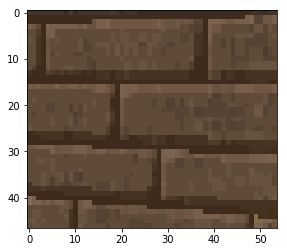

[ 109.90937746   49.97557132   43.3356974 ]


In [201]:
plt.imshow(frame8)
plt.show()
print(rgb_frame3)

In [ ]:
frames = observation[210:270, :]
frame1 = frames[:, 1:128]
frame2 = frames[:, 129:256]
frame3 = frames[:, 257:384]
frame4 = frames[:, 384:512]
frame5 = frames[:. 513:640]

In [17]:
env.close()

In [155]:
# THIS IS FOR 10 FRAMES!!!
for i_episode in range(10):
    observation = env.reset()
    for t in range(30):
        env.render()
        # print(observation.shape)
        action = [0]*43
        action[14] = 1
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

In [4]:
env.action_space.sample()

[1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -2,
 2,
 -97,
 -40,
 32]

In [36]:
env.observation_space

Box(480, 640, 3)

In [29]:
def q_learning(game, num_episodes, alpha=0.85, discount_factor=0.99):
    """
    Q learning algorithm, off-polics TD control. Finds optimal gready policies
    Args:
    env: Given environment to solve
    num_episodes: Number of episodes to learn
    alpha: learning rate
    discount factor: weight/importance given to future rewards
    epsilon: probability of taking random action. 
             We are using decaying epsilon, 
             i.e high randomness at beginning and low towards end
    Returns:
    Optimal Q
    """
     
    # decaying epsilon, i.e we will divide num of episodes passed
    epsilon = 1.0
    # create a numpy array filled with zeros 
    # rows = number of observations & cols = possible actions
    actions = []
    actions_num = game.get_available_buttons_size()
    Q = np.zeros([env.observation_space.shape[0], actions_num]) 
    for perm in it.product([False, True], repeat=actions_num):
        actions.append(list(perm))
    for i_episode in range(num_episodes):
            # reset the env
            state = game.get_state()
            # itertools.count() has similar to 'while True:'
            for t in itertools.count():
                # generate a random num between 0 and 1 e.g. 0.35, 0.73 etc..
                # if the generated num is smaller than epsilon, we follow exploration policy 
                if np.random.random() <= epsilon:
                    # select a random action from set of all actions
                    action = choice(actions)
                # if the generated num is greater than epsilon, we follow exploitation policy
                else:
                    # select an action with highest value for current state
                    action = np.argmax(Q[state, :])
                
                # apply selected action, collect values for next_state and reward
                reward = game.make_action(action)
                next_state,  done, _ = env.step(action)
                
                # Calculate the Q-learning target value
                Q_target = reward + discount_factor*np.max(Q[next_state,:])
                # Calculate the difference/error between target and current Q
                Q_delta = Q_target - Q[state,action]
                # Update the Q table, alpha is the learning rate
                Q[state, action] = Q[state, action] + (alpha * Q_delta)
                
                # break if done, i.e. if end of this episode
                if done:
                    break
                # make the next_state into current state as we go for next iteration
                state = next_state
            # gradualy decay the epsilon
            if epsilon > 0.1:
                epsilon -= 1.0/num_episodes
    
    return Q    # return optimal Q

In [32]:
import numpy as np
import itertools

In [33]:
Q = q_learning(env, 2000)

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (480,640,3) (43,) 

In [25]:
env.action_space.shape

43

In [49]:
from __future__ import print_function

import itertools as it
from random import choice
from time import sleep
from vizdoom import DoomGame, ScreenResolution
import time

game = DoomGame()

game.load_config("defend_the_line.cfg")
game.set_screen_resolution(ScreenResolution.RES_640X480)
game.set_window_visible(True)
game.init()

# Creates all possible actions depending on how many buttons there are.
actions_num = game.get_available_buttons_size()
actions = []
for perm in it.product([False, True], repeat=actions_num):
    actions.append(list(perm))

episodes = 10
sleep_time = 0.028

for i in range(episodes):
    print("Episode #" + str(i + 1))

    # Not needed for the first episode but the loop is nicer.
    game.new_episode()
    while not game.is_episode_finished():

        # Gets the state and possibly to something with it
        state = game.get_state()

        # Makes a random action and save the reward.
        reward = game.make_action(choice(actions))

        print("State #" + str(state.number))
        print("Game Variables:", state.game_variables)
        print("Performed action:", game.get_last_action())
        print("Last Reward:", reward)
        print("=====================")

        # Sleep some time because processing is too fast to watch.
        if sleep_time > 0:
            sleep(sleep_time)

    print("Episode finished!")
    print("total reward:", game.get_total_reward())
print("************************")

Episode #1
State #1
Game Variables: [  79.  100.]
Performed action: [1.0, 0.0, 1.0]
Last Reward: 0.0
State #2
Game Variables: [  80.  100.]
Performed action: [1.0, 0.0, 0.0]
Last Reward: 0.0
State #3
Game Variables: [  81.  100.]
Performed action: [0.0, 1.0, 1.0]
Last Reward: 0.0
State #4
Game Variables: [  82.  100.]
Performed action: [1.0, 0.0, 1.0]
Last Reward: 0.0
State #5
Game Variables: [  83.  100.]
Performed action: [0.0, 1.0, 1.0]
Last Reward: 0.0
State #6
Game Variables: [  84.  100.]
Performed action: [0.0, 1.0, 0.0]
Last Reward: 0.0
State #7
Game Variables: [  85.  100.]
Performed action: [0.0, 0.0, 0.0]
Last Reward: 0.0
State #8
Game Variables: [  86.  100.]
Performed action: [1.0, 0.0, 0.0]
Last Reward: 0.0
State #9
Game Variables: [  87.  100.]
Performed action: [0.0, 0.0, 1.0]
Last Reward: 1.0
State #10
Game Variables: [  87.  100.]
Performed action: [1.0, 0.0, 1.0]
Last Reward: 0.0
State #11
Game Variables: [  88.  100.]
Performed action: [1.0, 0.0, 1.0]
Last Reward: 0

State #77
Game Variables: [ 150.  100.]
Performed action: [1.0, 0.0, 1.0]
Last Reward: 0.0
State #78
Game Variables: [ 151.  100.]
Performed action: [0.0, 0.0, 0.0]
Last Reward: 0.0
State #79
Game Variables: [ 152.  100.]
Performed action: [0.0, 0.0, 0.0]
Last Reward: 0.0
State #80
Game Variables: [ 153.  100.]
Performed action: [1.0, 0.0, 1.0]
Last Reward: 0.0
State #81
Game Variables: [ 154.  100.]
Performed action: [0.0, 0.0, 0.0]
Last Reward: 0.0
State #82
Game Variables: [ 155.  100.]
Performed action: [0.0, 1.0, 1.0]
Last Reward: 0.0
State #83
Game Variables: [ 156.  100.]
Performed action: [0.0, 1.0, 0.0]
Last Reward: 0.0
State #84
Game Variables: [ 157.  100.]
Performed action: [0.0, 1.0, 0.0]
Last Reward: 0.0
State #85
Game Variables: [ 157.  100.]
Performed action: [1.0, 1.0, 1.0]
Last Reward: 0.0
State #86
Game Variables: [ 158.  100.]
Performed action: [0.0, 0.0, 1.0]
Last Reward: 0.0
State #87
Game Variables: [ 159.  100.]
Performed action: [0.0, 0.0, 1.0]
Last Reward: 0.0

State #152
Game Variables: [ 200.   88.]
Performed action: [0.0, 1.0, 0.0]
Last Reward: 0.0
State #153
Game Variables: [ 200.   88.]
Performed action: [0.0, 0.0, 1.0]
Last Reward: 0.0
State #154
Game Variables: [ 200.   88.]
Performed action: [1.0, 1.0, 1.0]
Last Reward: 1.0
State #155
Game Variables: [ 200.   88.]
Performed action: [0.0, 0.0, 1.0]
Last Reward: 0.0
State #156
Game Variables: [ 200.   88.]
Performed action: [1.0, 0.0, 1.0]
Last Reward: 0.0
State #157
Game Variables: [ 200.   88.]
Performed action: [1.0, 0.0, 0.0]
Last Reward: 0.0
State #158
Game Variables: [ 200.   88.]
Performed action: [1.0, 1.0, 0.0]
Last Reward: 0.0
State #159
Game Variables: [ 200.   88.]
Performed action: [1.0, 1.0, 0.0]
Last Reward: 0.0
State #160
Game Variables: [ 200.   88.]
Performed action: [1.0, 0.0, 0.0]
Last Reward: 0.0
State #161
Game Variables: [ 200.   88.]
Performed action: [0.0, 0.0, 1.0]
Last Reward: 0.0
State #162
Game Variables: [ 200.   88.]
Performed action: [0.0, 1.0, 1.0]
Last 

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [46]:
game.set_death_penalty()

1.0

In [47]:
actions_num = game.get_available_buttons_size()
actions_num

3

In [48]:
 game.get_last_action()

[1.0, 0.0, 1.0]